In [1]:
from pettingzoo.classic import connect_four_v3

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

# Using the PettingZoo environment

This notebook provides smalls chunks of code to get you started with the Connect4 project. You do not have to use this code in you final file, but you can if you wish to. 

In [3]:
env = connect_four_v3.env(render_mode="rgb_array")

env.reset()

# The main difference with the standard gym api is the way the environment is queried. The `step` method return `None`. To get the data on the environment, use the `last` method
state, reward, terminated, truncated, info = env.last()

# state is a dictionary with two keys: observation and action_mask
print(
    state["observation"].shape
)  # Observation is a numpy array with three coordinates, indicating the positions of the pieces of of player 0 and 1 on the the board
print(state["observation"][:, :, 0])  # Where the pieces of player 0 are
print(state["observation"][:, :, 1])  # Where the pieces of player 1 are

print(state["action_mask"])  # an array showing whether the actions are legal or nots


(6, 7, 2)
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[1 1 1 1 1 1 1]


# Agents

Here are some implementations of trivial agents that you should be able to beat ultimately. 

In [4]:
class RandomPlayer:
    def __init__(self, rng=None):
        if rng is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = rng

        self.name = "Random Player"

    def get_action(self, obs_mask, epsilon=None):
        return self.random_choice_with_mask(np.arange(7), obs_mask["action_mask"])

    def random_choice_with_mask(self, arr, mask):
        masked_arr = np.ma.masked_array(arr, mask=1 - mask)
        if masked_arr.count() == 0:
            return None
        return self.rng.choice(masked_arr.compressed())


In [5]:
class PlayLeftmostLegal:
    def __init__(self):
        self.name = "Left Player"

    def get_action(self, obs_mask, epsilon=None):
        for i, legal in enumerate(obs_mask["action_mask"]):
            if legal:
                return i
        return None


# Running a game


The following function runs a full game between the two agents. 

In [6]:
def play_game(env, agent0, agent1, display=False):
    done = False
    env.reset()
    obs, _, _, _, _ = env.last()
    while not done:
        for i, agent in enumerate([agent0, agent1]):
            action = agent.get_action(obs, epsilon=0)
            env.step(action)
            if display:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
            obs, reward, terminated, _, _ = env.last()
            done = terminated
            if np.sum(obs["action_mask"]) == 0:
                if display: 
                    print('Draw')
                return 0.5
            if done:
                if display:
                    print(f"Player {i}: {agent.name} won")
                    print(obs['observation'][:, :, 0]- obs['observation'][:, :, 1])
                return i

# Emulating a Gym environment

If we fix the opposite policy, the game from the point of view of the agent is equivalent to a Gym environment. The following class implements this simulation. Then any algorithm that would work in a gym environment with the same observations will work here. 

Note that we implemented the possibility to be the first or the second player. 

In [7]:
class EnvAgainstPolicy: 
    def __init__(self, env, policy, first_player=True):
        self.policy = policy
        self.env = env
        self.first_player = first_player
        self.reset()

    def step(self, action):
        self.env.step(action)
        obs, reward, terminated, _, _ = self.env.last()
        if terminated: 
            self.last_step = obs, reward, True, False, {}
        else: 
            action = self.policy.get_action(obs)
            self.env.step(action)
            obs, reward, terminated, _, _ = self.env.last()
            self.last_step = obs, -reward, terminated, False, {}
        return self.last_step

    def reset(self):
        self.env.reset()
        if not(self.first_player): 
            obs, _, _, _, _ = self.env.last()
            action = self.policy.get_action(obs)
            self.env.step(action)

        self.last_step = self.env.last()
        return self.last_step

    def last(self):
        return self.last_step

# Evaluating an agent against a fixed policy: 

Using the environment above, we can evaluate the agent against this fixed policy. 

In [8]:
def eval_against_policy(env, agent, policy, N_episodes=10, first_player=True):
    eval_env = EnvAgainstPolicy(env, policy, first_player=first_player)
    results = []
    for _ in range(N_episodes):
        done = False
        eval_env.reset()
        obs, _, _, _, _ = eval_env.last()
        while not done:
            action = agent.get_action(obs, epsilon=0)
            eval_env.step(action)
            obs, reward, done, _, _ = eval_env.last()
        results.append(reward)
    return results

We can see that if both players play randomly, there is a small but significant advantage to the first player. 

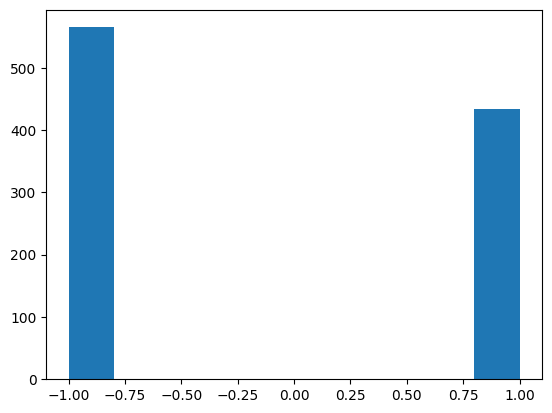

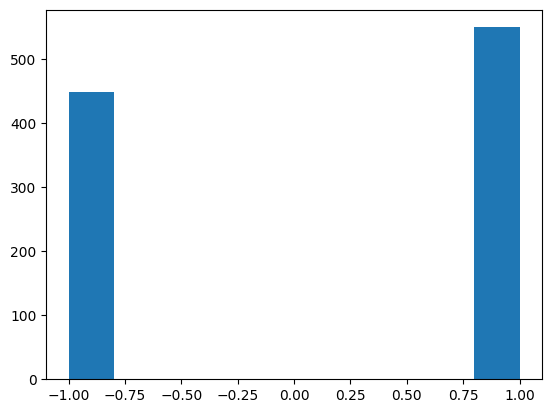

In [9]:
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=False))
plt.show()
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=True))
plt.show()

# Your turn 

Try to build a decent agent. Be creative! You can try any idea that you have: the grade is not about performance of the agent, but more about illustrating phenomena happening in Reinforcement Learning for turn-based games. It's okay to 'help' the agent in any way, as long as it follows the ideas of RL (i.e., as long as there is some learning involved).




In [10]:
import torch
import random

In [11]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, terminated, next_state):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, terminated, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.choices(self.memory, k=batch_size)

    def __len__(self):
        return len(self.memory)

# create instance of replay buffer
#replay_buffer = ReplayBuffer(BUFFER_CAPACITY)

In [12]:
class Model(torch.torch.nn.Module):
    def __init__(self, input_size, output_size = 7, n_hidden_layers=1, hidden_dim = 16):
        super(Model, self).__init__()
        self.input_size = input_size
        
        net = [torch.nn.Linear(input_size, hidden_dim), torch.nn.ReLU()]
        net.extend([torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU()] * n_hidden_layers)
        net.append(torch.nn.Linear(hidden_dim, output_size))
        net.append(torch.nn.Sigmoid())  #sigmoid is important as we will take the argmax with masking (values forced to 0), we don't want negative values

        self.network = torch.nn.Sequential(*net)

    def forward(self, x):
        x = x.float().unsqueeze(0).view(-1, self.input_size)
        return self.network(x)
    
class ModelCNN(torch.torch.nn.Module):
    def __init__(self, input_size, output_size = 7, n_hidden_layers=1, hidden_dim = 4):
        super(ModelCNN, self).__init__()
        self.input_size = input_size
        
        net = [torch.nn.Conv2d(1, hidden_dim, kernel_size=3, stride=1, padding=1), torch.nn.ReLU()]
        net.extend([torch.nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1), torch.nn.ReLU()] * n_hidden_layers)

        net.append(torch.nn.Flatten())
        net.append(torch.nn.Linear(hidden_dim*input_size, output_size))
        net.append(torch.nn.Sigmoid())  #sigmoid is important as we will take the argmax with masking (values forced to 0), we don't want negative values

        self.network = torch.nn.Sequential(*net)

    def forward(self, x):
        if x.ndim == 2:
            x = x.unsqueeze(0)
        x = x.float().unsqueeze(1)
        return self.network(x)

In [13]:
class NotDumbAgent: 
    def __init__(self,
                action_space,
                observation_space,
                gamma,
                batch_size,
                buffer_capacity,
                update_target_every, 
                epsilon_start, 
                decrease_epsilon_factor, 
                epsilon_min,
                learning_rate,
                name, n_hidden_layers=1, hidden_dim = 16,
                use_CNN = False 
                ): 
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma
        
        self.batch_size = batch_size
        self.buffer_capacity = buffer_capacity
        self.update_target_every = update_target_every
        
        self.epsilon_start = epsilon_start
        self.decrease_epsilon_factor = decrease_epsilon_factor # larger -> more exploration
        self.epsilon_min = epsilon_min
        
        self.learning_rate = learning_rate

        self.name = name
        self.n_hidden_layers = n_hidden_layers
        self.hidden_dim = hidden_dim
        self.use_CNN = use_CNN
        
        self.reset()
        
    def get_action(self, state, epsilon=None):
        if epsilon is None and np.random.rand() < self.epsilon: 
            masked_arr = np.ma.masked_array(np.arange(7), mask=1 - state['action_mask'])
            if masked_arr.count() == 0:
                return None
            return np.random.choice(masked_arr.compressed())
        
        output = self.get_q(state)
        output *= state['action_mask']
        return np.argmax(output)
    
        
    
    def update(self, state, action, reward, terminated, next_state):
        """
        Updates the buffer and the network(s)
        """
        # add data to replay buffer
        self.buffer.push(torch.tensor(state['observation']).unsqueeze(0), 
                           torch.tensor([[action]], dtype=torch.int64), 
                           torch.tensor([reward]), 
                           torch.tensor([terminated], dtype=torch.int64), 
                           torch.tensor(next_state['observation']).unsqueeze(0),
                          )

        if len(self.buffer) < self.batch_size:
            return np.inf

        # get batch
        transitions = self.buffer.sample(self.batch_size)

        # Compute loss
        state_batch, action_batch, reward_batch, terminated_batch, next_state_batch = tuple(
            [torch.cat(data) for data in zip(*transitions)]
        )

        values  = self.q_net.forward(state_batch[..., 0] - state_batch[..., 1]).gather(1, action_batch)

        # Compute the ideal Q values
        with torch.no_grad():
            next_state_values = (1 - terminated_batch) * self.target_net(next_state_batch[..., 0] - next_state_batch[..., 1]).max(1)[0]
            targets = next_state_values * self.gamma + reward_batch

        loss = self.loss_function(values, targets.unsqueeze(1))

        # Optimize the model 
        self.optimizer.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_value_(self.q_net.parameters(), 100)
        self.optimizer.step()
        
        if not((self.n_steps+1) % self.update_target_every): 
            self.target_net.load_state_dict(self.q_net.state_dict())
            
        self.decrease_epsilon()
            
        self.n_steps += 1
        if terminated: 
            self.n_eps += 1

        return loss.detach().numpy()
    
    def get_q(self, state):
        """
        Compute Q function for a states
        """
        input = torch.tensor(state['observation'][..., 0] - state['observation'][..., 1])
        with torch.no_grad():
            output = self.q_net(input).squeeze(0).numpy()
        return output
    
    def decrease_epsilon(self):
        self.epsilon = self.epsilon_min + (self.epsilon_start - self.epsilon_min) * (
                        np.exp(-1. * self.n_eps / self.decrease_epsilon_factor ) )
    
    def reset(self):              
        self.buffer = ReplayBuffer(self.buffer_capacity)
        if self.use_CNN:
            self.q_net =  ModelCNN(42, output_size=7, n_hidden_layers=self.n_hidden_layers, hidden_dim=self.hidden_dim)
            self.target_net = ModelCNN(42, output_size=7, n_hidden_layers=self.n_hidden_layers, hidden_dim=self.hidden_dim)
        else:
            self.q_net =  Model(42, output_size=7, n_hidden_layers=self.n_hidden_layers, hidden_dim=self.hidden_dim)
            self.target_net = Model(42, output_size=7, n_hidden_layers=self.n_hidden_layers, hidden_dim=self.hidden_dim)

        self.loss_function = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(params=self.q_net.parameters(), lr=self.learning_rate)
        
        self.epsilon = self.epsilon_start
        self.n_steps = 0
        self.n_eps = 0

In [14]:
def eval_agent(agent0, agent1, env, n_sim=5):
    """
    ** Solution **
    
    Monte Carlo evaluation of DQN agent.

    Repeat n_sim times:
        * Run the DQN policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    episode_rewards = np.zeros(n_sim)
    for i in range(n_sim):
        env.reset()
        state, _, _, _, _ = env.last()
        reward_sum = 0
        done = False
        while not done: 
            action = agent0.get_action(state, epsilon=0)
            env.step(action)
            state, reward, terminated, truncated, info = env.last()
            reward_sum += reward
            done = terminated or truncated

            if done:
                break

            action = agent1.get_action(state)
            env.step(action)
            state, reward, terminated, truncated, info = env.last()
            done = terminated or truncated

        episode_rewards[i] = reward_sum
    return episode_rewards

In [15]:
def train(env, agent0, agent1, N_episodes, eval_every=10, reward_threshold=0.999, verbose=True, dual=False):
    """The first agent is the one we want to train"""
    losses = []
    max_reward=0
    for ep in range(N_episodes):
        done = False
        env.reset()
        state, _, _, _, _ = env.last()
        while not done: 
            for i, agent in enumerate([agent0, agent1]):
                next_state, reward, terminated, truncated, info = env.last()
                done = terminated or truncated

                if done:
                    break 
                
                action = agent.get_action(next_state)
                env.step(action)
                if dual or i==0:
                    loss_val = agent.update(state, action, reward, terminated, next_state)
                    losses.append(loss_val)
                state = next_state      

        if ((ep+1)% eval_every == 0):
            rewards = eval_agent(agent0, agent1, env, n_sim=100)
            if verbose:
                print(f"episode = {ep+1}, reward = {np.mean(rewards):.2f}", end='\r')
            if np.mean(rewards) > max_reward:
                max_reward = np.mean(rewards)
            if np.mean(rewards) >= reward_threshold:
                break
    print(f"Max reward during training: {max_reward}")
    return losses, max_reward

In [16]:
action_space = env.action_space
observation_space = env.observation_space

N_episodes = 1000

gamma = 0.95
batch_size = 8
buffer_capacity = 100

epsilon_start = 0.9
decrease_epsilon_factor = 1000
epsilon_min = 0.05

learning_rate = 1e-2

list_update_target_every = [2**i for i in range(3, 6)]
list_n_hidden_layers = [i for i in range(4)]
list_hidden_dim = [16, 32, 64]


In [ ]:
random_agent = RandomPlayer()
results = {}
for update_target_every in list_update_target_every:
    for n_hidden_layers in list_n_hidden_layers:
        for hidden_dim in list_hidden_dim[:1]:
            DQN_agent = NotDumbAgent(action_space, observation_space, gamma, batch_size, buffer_capacity, update_target_every, epsilon_start, decrease_epsilon_factor, epsilon_min, learning_rate, "Dumbo", n_hidden_layers=n_hidden_layers, hidden_dim=hidden_dim)
            train_losses, max_reward = train(env, DQN_agent, random_agent, N_episodes=N_episodes, eval_every=50)
            results[(update_target_every, n_hidden_layers, hidden_dim)] = max_reward

In [ ]:
print(results)
print(sorted(results.items(), key=lambda x:x[1], reverse=True))

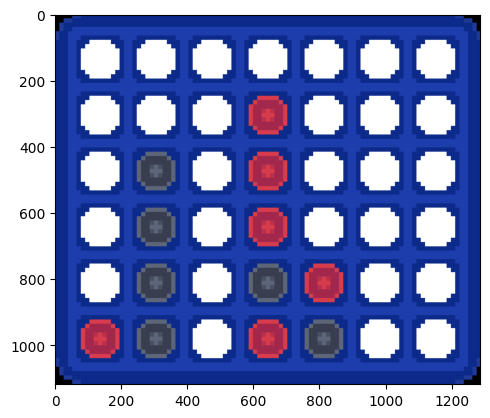

Player 1: Dumbo 2 le retour won
[[ 0  0  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0]
 [ 0  1  0 -1  0  0  0]
 [ 0  1  0 -1  0  0  0]
 [ 0  1  0  1 -1  0  0]
 [-1  1  0 -1  1  0  0]]


1

In [39]:
play_game(env, DQN_agent, random_agent, display=True)

In [ ]:
random_agent = RandomPlayer()
results = {}
for update_target_every in list_update_target_every:
    for n_hidden_layers in list_n_hidden_layers:
        DQN_agent = NotDumbAgent(action_space, observation_space, gamma, batch_size, buffer_capacity, update_target_every, epsilon_start, decrease_epsilon_factor, epsilon_min, learning_rate, "Dumbledore", n_hidden_layers=n_hidden_layers, hidden_dim=16, use_CNN=True)
        train_losses, max_reward = train(env, DQN_agent, random_agent, N_episodes=N_episodes, eval_every=50)
        results[(update_target_every, n_hidden_layers, hidden_dim)] = max_reward
print(results)

In [ ]:
random_agent = RandomPlayer()

for hidden_dim in list_hidden_dim:
    DQN_agent = NotDumbAgent(action_space, observation_space, gamma, batch_size, buffer_capacity, 16, epsilon_start, decrease_epsilon_factor, epsilon_min, learning_rate, "Dumbo", n_hidden_layers=3, hidden_dim=hidden_dim, use_CNN=True)
    print("hidden_dim = ", hidden_dim)
    train(env, DQN_agent, random_agent, N_episodes=N_episodes, eval_every=50)